**Install Necessary Libraries**

In [ ]:
!pip install shapely==1.6.4
!pip install scikit-learn==0.19.1
!pip install geopandas==0.4.0
!pip install geoplot==0.2.3
!pip install quilt==2.9.15

**Mount Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Import Quilt**

In [ ]:
import quilt
quilt.install("ResidentMario/geoplot_data")

**Cleaning up the AirBNB data for further analysis**

In [ ]:
def clean_airBNB_data(path):

    '''Provided a local path to the kaggle data linked in introduction, extracts all data to numerical features, 
    including turning categories into dummy variables. Also creates a geometry column as a shapely point object for plotting
    '''
    
    import numpy as np
    import pandas as pd
    from shapely.geometry import Point
    import matplotlib.pyplot as plt
    from sklearn.preprocessing import Imputer
    import warnings
    warnings.filterwarnings('ignore')

    # read data
    df = pd.read_csv(path)
    
    # these are catagorical variables, they need to be dummied
    cat_list = ['host_is_superhost','host_has_profile_pic','host_identity_verified','is_location_exact',
                'instant_bookable','require_guest_profile_picture','require_guest_phone_verification',
                'property_type','room_type','bed_type']

    cat_df = pd.get_dummies(df[cat_list], prefix=cat_list, drop_first=True)

    # keep numerical data where are least half of the rows have some data, ignoring the rest
    num_df = df.select_dtypes(['int','float'])
    num_df = num_df[num_df.columns[num_df.isnull().sum()/num_df.shape[0] < 0.5]]

    # impute missing values with mean of that column
    imp = Imputer()
    num_df = pd.DataFrame(columns=num_df.columns, data=imp.fit_transform(num_df))

    # these variables are strings that need converting to floats
    dollar_list = ['price','security_deposit','extra_people','cleaning_fee', 'host_acceptance_rate']

    dol_df = df[dollar_list]
    for entry in dollar_list:
        row_num = df[entry].str.extract('(\d+)').values.astype('float')
        dol_df.loc[:,entry + '_num'] = row_num

    dol_df.drop(dollar_list, axis=1, inplace=True)

    # this varible has lots of missing values
    dol_df['host_acceptance_rate_num'].fillna(dol_df['host_acceptance_rate_num'].mean(), inplace=True)
    dol_df.fillna(0, inplace=True)

    # extract out the amenities column, which has a list of amenities for each row, which need to be extracted, and dummied
    amenities = df['amenities'].str.split('([A-Z][\w ]+)', expand=True)

    # split creates columns for stuff in between groups too, ignore those
    i = 1
    for col in amenities.columns:
        if i%2 == 1:
            amenities.drop(col, axis=1, inplace=True)
        i += 1

    # explictly loop through every entry to keep track of categorical dummies, since everything is jumbled and out of order
    rows = amenities.shape[0]
    columns = amenities.shape[1]

    to_drop = amenities.columns

    for i in range(rows):
        for j in range(columns):

            entry = amenities.iloc[i,j]

            if entry:
                amenities.loc[i, entry + '_bin'] = 1

    amenities.drop(to_drop, axis=1, inplace=True)
    
    # everything that was not assigned a 1 is logically now a 0
    amenities.fillna(0, inplace=True)

    # combine all the various extracted data back together
    clean_df_amen = pd.concat((cat_df, dol_df, num_df, amenities), axis=1)
    clean_df = pd.concat((cat_df, dol_df, num_df), axis=1)

    # add in a location column as a shapely point object for geopandas map plotting
    df['geometry'] = list(zip(df.longitude, df.latitude))
    clean_df['geometry'] = df['geometry'].apply(Point)
    clean_df_amen['geometry'] = df['geometry'].apply(Point)
    
    # also keep track of zipcode, since this will serve as a join for plotting
    clean_df['zipcode'] = pd.to_numeric(df['zipcode'], errors='coerce')
    clean_df_amen['zipcode'] = pd.to_numeric(df['zipcode'], errors='coerce')
        
    ''' clean_df: which is all cleaned data except the amenities column
        clean_df_amen: which additional splits out the amenities column into categorical dummies
    '''
    return clean_df, clean_df_amen

In [ ]:
clean_df, clean_df_amen = clean_airBNB_data('listings.csv')

In [ ]:
clean_df.head()

,host_is_superhost_t,host_has_profile_pic_t,host_identity_verified_t,is_location_exact_t,instant_bookable_t,require_guest_profile_picture_t,require_guest_phone_verification_t,property_type_Bed & Breakfast,property_type_Boat,property_type_Camper/RV,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,geometry,zipcode
0,0,1,0,1,0,0,0,0,0,0,...,91.916667,9.431571,9.258041,9.646293,9.646549,9.414043,9.168234,1.970908,POINT (-71.13306792912681 42.28261879577949),2131.0
1,0,1,1,1,1,0,0,0,0,0,...,94.000000,10.000000,9.000000,10.000000,10.000000,9.000000,9.000000,1.300000,POINT (-71.13437396457161 42.28624082186742),2131.0
2,1,1,1,1,0,1,0,0,0,0,...,98.000000,10.000000,9.000000,10.000000,10.000000,9.000000,10.000000,0.470000,POINT (-71.13576525374667 42.29243788665679),2131.0
3,0,1,0,0,0,0,0,0,0,0,...,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,POINT (-71.12102117350554 42.28110618827365),NaN
4,1,1,1,1,0,0,0,0,0,0,...,99.000000,10.000000,10.000000,10.000000,10.000000,9.000000,10.000000,2.250000,POINT (-71.1362580468337 42.28451220982457),2131.0


In [ ]:
clean_df.shape

(3585, 45)

In [ ]:
clean_df_amen.head()

,host_is_superhost_t,host_has_profile_pic_t,host_identity_verified_t,is_location_exact_t,instant_bookable_t,require_guest_profile_picture_t,require_guest_phone_verification_t,property_type_Bed & Breakfast,property_type_Boat,property_type_Camper/RV,...,Smoking Allowed_bin,Suitable for Events_bin,Wheelchair Accessible_bin,Elevator in Building_bin,Pool_bin,Doorman_bin,Paid Parking Off Premises_bin,Free Parking on Street_bin,geometry,zipcode
0,0,1,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,POINT (-71.13306792912681 42.28261879577949),2131.0
1,0,1,1,1,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,POINT (-71.13437396457161 42.28624082186742),2131.0
2,1,1,1,1,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,POINT (-71.13576525374667 42.29243788665679),2131.0
3,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,POINT (-71.12102117350554 42.28110618827365),NaN
4,1,1,1,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,POINT (-71.1362580468337 42.28451220982457),2131.0


In [ ]:
clean_df_amen.shape

(3585, 90)

In [ ]:
clean_df.isna().sum()

host_is_superhost_t                    0
host_has_profile_pic_t                 0
host_identity_verified_t               0
is_location_exact_t                    0
instant_bookable_t                     0
require_guest_profile_picture_t        0
require_guest_phone_verification_t     0
property_type_Bed & Breakfast          0
property_type_Boat                     0
property_type_Camper/RV                0
property_type_Condominium              0
property_type_Dorm                     0
property_type_Entire Floor             0
property_type_Guesthouse               0
property_type_House                    0
property_type_Loft                     0
property_type_Other                    0
property_type_Townhouse                0
property_type_Villa                    0
room_type_Private room                 0
room_type_Shared room                  0
bed_type_Couch                         0
bed_type_Futon                         0
bed_type_Pull-out Sofa                 0
bed_type_Real Be

**Plot AirBnBs Across Boston**

In [ ]:
def make_map_plot(df, hue, agg_method, fig_name, title):
    
    '''Directly taken from the geoplot gallery example on aggplot, which plots the same data as analyzed here,
       but cleaning is not described in that case
    '''
    
    import geoplot as gplt
    import geoplot.crs as gcrs
    import numpy as np
    import matplotlib.pyplot as plt
    from quilt.data.ResidentMario import geoplot_data
    import geopandas as gpd
    import pandas as pd
    import numpy as np

    if agg_method == 'mean':
        agg = np.mean
    elif agg_method == 'median':
        agg = np.median
        
    # first you need to create a geopandas dataframe, which is like a pandas dataframe with coordinate attributes from shapely
    abb = gpd.GeoDataFrame(df, geometry='geometry')
    
    # nans will mess up plotting, also the 2218 zipcode is not contained in the map boudnaries for some reason
    abb.dropna(inplace=True)
    abb = abb[abb['zipcode'] != 2218.0]

    # read in .shp zipcode boundaries from ResidentMario's quilt database
    boston_zip_codes = gpd.read_file(geoplot_data.boston_zip_codes())
    boston_zip_codes = boston_zip_codes.assign(id=boston_zip_codes.id.astype(float)).set_index('id')

    # create the plot outlines of the zipcodes
    ax = gplt.polyplot(boston_zip_codes.geometry, projection=gcrs.AlbersEqualArea(),
                       facecolor='white', edgecolor='gray',figsize=(15,15), linewidth=0)
    
    plt.rcParams.update({'font.size': 22}) 
    
    # shade the regions based on price, as per example in geoplot gallery, should match that link and does for me
    gplt.aggplot(abb, projection=gcrs.AlbersEqualArea(), hue=hue,
                 by='zipcode', geometry=boston_zip_codes.geometry, agg=agg, ax=ax,
                 linewidth=0, legend_kwargs={'fraction': 0.045})
    
    ax.set_title(title, fontdict={'fontsize':28})
    plt.savefig(fig_name, bbox_inches='tight', pad_inches=0.1)

In [ ]:
def make_points_plot(df, hue, fig_name, title):
    
    '''Rather than an aggplot, this funciton will just make a scatter plot and color by hue instead'''
    
    import geoplot as gplt
    import geoplot.crs as gcrs
    import numpy as np
    import matplotlib.pyplot as plt
    from quilt.data.ResidentMario import geoplot_data
    import geopandas as gpd
    import pandas as pd
    import numpy as np
    from shapely.geometry import Point, Polygon
        
    # first you need to create a geopandas dataframe, which is like a pandas dataframe with coordinate attributes from shapely
    abb = gpd.GeoDataFrame(df, geometry='geometry')

    # read in .shp zipcode boundaries from ResidentMario's quilt database
    boston_zip_codes = gpd.read_file(geoplot_data.boston_zip_codes())
    boston_zip_codes = boston_zip_codes.assign(id=boston_zip_codes.id.astype(float)).set_index('id')
    
    # only keep those that are in the kaggle date
    boston_zip_codes = boston_zip_codes.loc[abb['zipcode'].unique(),:].dropna()

    # create the plot outlines of the zipcodes
    ax = gplt.polyplot(boston_zip_codes.geometry,facecolor='lightgray', alpha=0.2, edgecolor='gray',figsize=(15,15))
    gplt.pointplot(abb, hue=hue, cmap='viridis', ax=ax, legend=True);
    
    ax.set_title(title, fontdict={'fontsize':28})
    plt.savefig(fig_name, bbox_inches='tight', pad_inches=0.1)

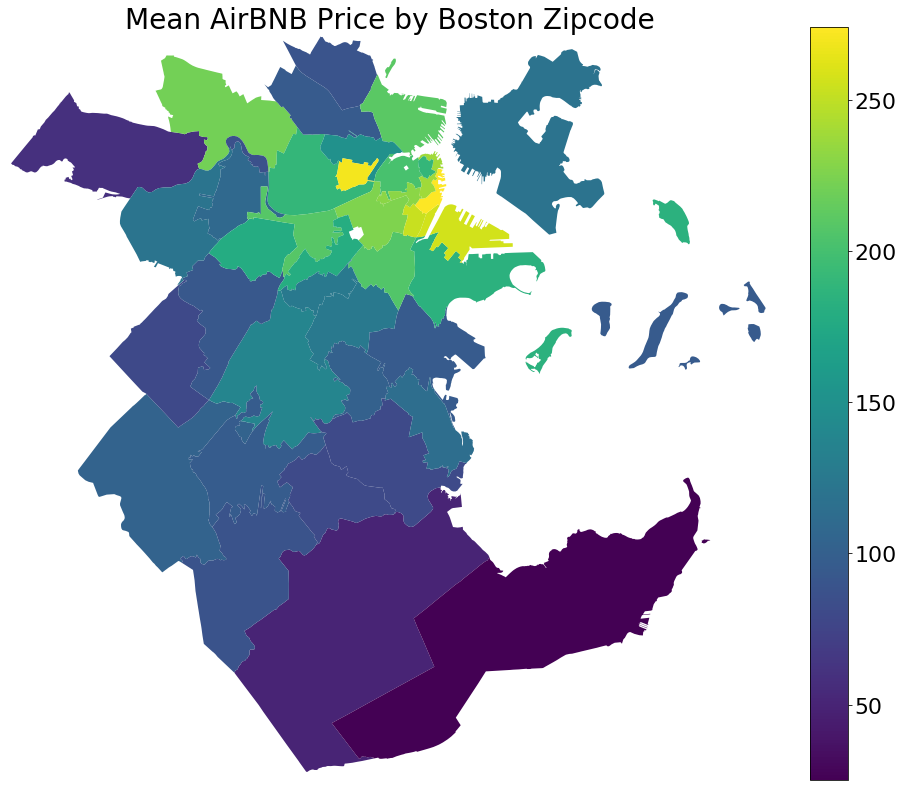

In [ ]:
make_map_plot(clean_df, 'price_num', 'mean', 'mean_airbnb_price.png', 'Mean AirBNB Price by Boston Zipcode')

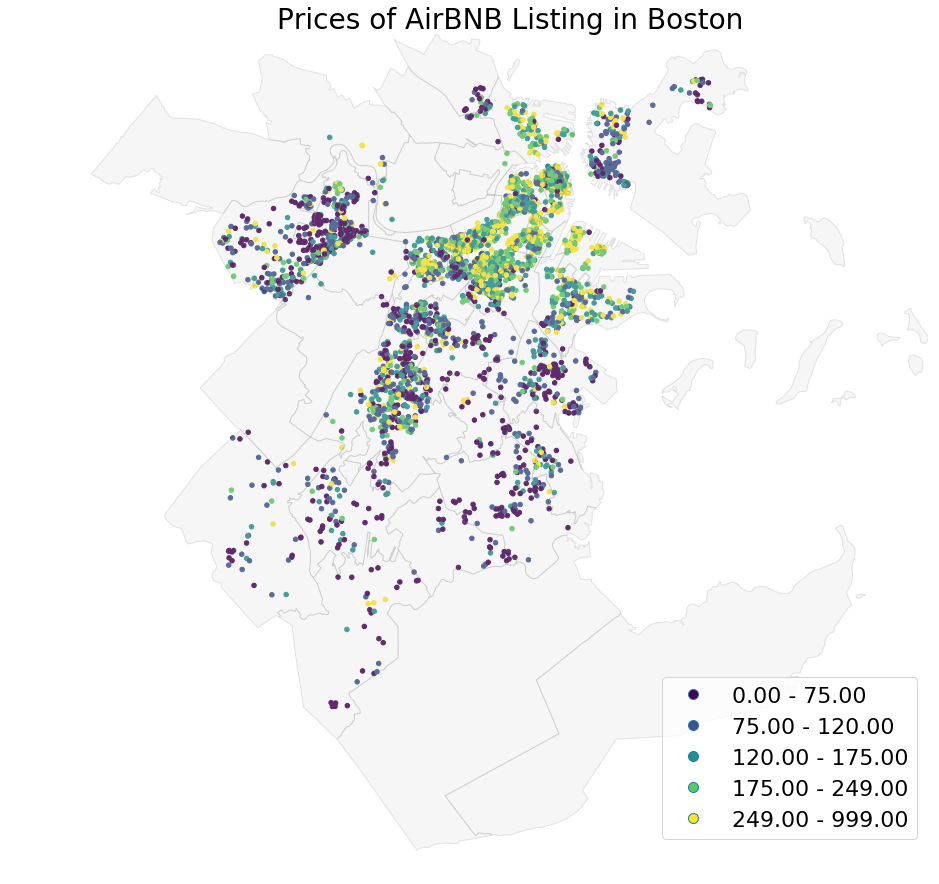

In [ ]:
make_points_plot(clean_df, 'price_num', 'airbnb_price_scatter.png', 'Prices of AirBNB Listing in Boston')